# DATA PREPARATION AND CLEANING

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.7 MB/s eta 0:00:00


In [ ]:
pip install fuzzywuzzy

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict
from sklearn.metrics import accuracy_score
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.read_csv('/content/drive/MyDrive/final_dataset_test.csv')

We first created the feature is killed and filtered the data to be in the range of years between
2014 and 2017, as required.

In [63]:
# filter the incidents where year is between 2014 and 2017 and create the is_killed label
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df[(df['year'] >= 2014) & (df['year'] <= 2017)]
df["is_killed"] = df["n_killed"] > 0

The names of the counties are not consistent, so we need to unify them. We will use fuzzywuzzy's matching to find similar names and try to preprocess the strings to minimize the number of typos and abbreviations. We will also remove punctuation characters and extra spaces, and transform the names to title case.

In [ ]:
print(df['city_or_county'].nunique())

11840


In [ ]:
# preprocess county names to unify typos and different abbreviations
counties = df['city_or_county'].unique()
# Apply a regex-based replacement to unify the "county" suffix
df['city_or_county'] = df['city_or_county'].str.replace(r'\s+\(county\)$', ' County', regex=True)
# Replace punctuation characters with spaces
df['city_or_county'] = df['city_or_county'].str.replace(r'[^\w\s]|(?<=\w)-(?=\w)', ' ', regex=True)
# Replace 'St ' with 'Saint'
df['city_or_county'] = df['city_or_county'].str.replace(r'\bSt\b', 'Saint', regex=True)
# Replace "Pk" with "Park"
df['city_or_county'] = df['city_or_county'].str.replace(r'\bPk\b', 'Park', regex=True)
# Replace "Mt" with "Mount"
df['city_or_county'] = df['city_or_county'].str.replace(r'\bMt\b', 'Mount', regex=True)
# Replace "Twp" with "Township"
df['city_or_county'] = df['city_or_county'].str.replace(r'\bTwp\b', 'Township', regex=True)
# Replace "Washingtn" with "Washington"
df['city_or_county'] = df['city_or_county'].str.replace(r'\bWashingtn\b', 'Washington', regex=True)

# Remove extra spaces
df['city_or_county'] = df['city_or_county'].str.replace(r'\s+', ' ', regex=True)
# Transform to title case and strip leading and trailing spaces
df['city_or_county'] = df['city_or_county'].str.strip().str.title()

In [ ]:
from fuzzywuzzy import fuzz
import pandas as pd

# Function to unify similar names using fuzzy matching
def unify_similar_names(names):
    mapping_dict = {}

    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            similarity_ratio = fuzz.ratio(names[i], names[j])
            if similarity_ratio > 90:  # Adjust the threshold as needed
                print(f"Similarity between '{names[i]}' and '{names[j]}' - Ratio: {similarity_ratio}")
                mapping_dict[names[j]] = names[i]

    return mapping_dict

# Assuming df is your DataFrame and 'city_or_county' is the column with county names
counties = df['city_or_county'].unique()

# Call the function to get the mapping dictionary
unify_dict_auto = unify_similar_names(counties)

# Apply the automatic mapping to unify similar names
df['city_or_county'] = df['city_or_county'].replace(unify_dict_auto)

Similarity between 'Ashville' and 'Asheville' - Ratio: 94
Similarity between 'Blount' and 'Blunt' - Ratio: 91
Similarity between 'Blountsville' and 'Blountville' - Ratio: 96
Similarity between 'Bryant' and 'Bryan' - Ratio: 91
Similarity between 'Bullock County' and 'Bulloch County' - Ratio: 93
Similarity between 'Centreville' and 'Centerville' - Ratio: 91
Similarity between 'Clanton' and 'Canton' - Ratio: 92
Similarity between 'Coaling' and 'Coalinga' - Ratio: 93
Similarity between 'Coden' and 'Cowden' - Ratio: 91
Similarity between 'Coden' and 'Colden' - Ratio: 91
Similarity between 'Coosa County' and 'Catoosa County' - Ratio: 92
Similarity between 'Coosa County' and 'Coos County' - Ratio: 96
Similarity between 'Danville' and 'Dansville' - Ratio: 94
Similarity between 'Duncanville' and 'Duncansville' - Ratio: 96
Similarity between 'Elkmont' and 'Elmont' - Ratio: 92
Similarity between 'Fayette County' and 'Payette County' - Ratio: 93
Similarity between 'Fort Deposit' and 'Port Deposit'

In [ ]:
print(df['city_or_county'].nunique())

10902


In [ ]:
df.to_csv('/content/drive/MyDrive/TASK4DATA.csv', index=False)


We will calculate a score for each incident, based on the number of participants and how serious it was. We will assign heavier weights to incidents with more victims, and we will also consider the number of unharmed participants as negative weight. Then, we will group the incidents by year and week, to calculate the sum of the scores for each week later.

In [13]:
# Extract a time series for each city, computing for each week of the 4 years a score
df['date'] = pd.to_datetime(df['date'])
df['score'] = df.n_participants + df.n_killed * (
        2 + df.n_killed / df.n_participants) + df.n_injured - 0.25 * df.n_unharmed

In [14]:
# Define a function to calculate the unique week index considering leap years
def calculate_unique_week(date):
    if date.year == 2016:  # account for the leap year
        return date.isocalendar().week + (date.year - 2014) * 53
    else:
        return date.isocalendar().week + (date.year - 2014) * 52

# Apply the function to create the unique week index column
df['week'] = df['date'].apply(calculate_unique_week)

Filter cities to retain only those with a substantial number of incidents. Calculate the percentage of weeks with incidents for each city and retain cities where the percentage exceeds 25%. This approach aims to mitigate the presence of excessive missing values in the time series data.  By setting a 25% threshold, the goal is to prioritize cities where incidents are consistently observed over time.

In [15]:
# Group by city and week, count incidents, and calculate score
grouped = df.groupby([df['city_or_county'],
                      df['week']]).size().reset_index(name='incident_count')
# Count total weeks for each city
city_week_counts = grouped['city_or_county'].value_counts()

# Calculate the total number of weeks from 2014 to 2017
total_weeks = len(grouped['week'].unique())

# Calculate percentage of weeks with incidents for each city
city_week_percentage = city_week_counts / total_weeks

# Filter cities with more than 25% weeks with incidents
selected_cities = city_week_percentage[city_week_percentage > 0.25].index
filtered = df[df['city_or_county'].isin(selected_cities)]
# Filter the grouped DataFrame for selected cities
filtered_grouped = filtered.groupby([df['city_or_county'],
                                     df['week']])['score'].sum().reset_index()

In [16]:
filtered_grouped.sort_values(by='score',ascending =False).head(1000)

city_or_county  week       score
8164             Chicago   159  337.583333
31503             Orland   129  297.771845
8163             Chicago   158  285.916667
8162             Chicago   157  272.958333
8194             Chicago   189  263.166667
8187             Chicago   182  258.250000
8189             Chicago   184  255.000000
8145             Chicago   140  249.666667
8185             Chicago   180  247.750000
8188             Chicago   183  239.916667
8181             Chicago   176  239.583333
8094             Chicago    88  236.333333
8135             Chicago   130  234.500000
8183             Chicago   178  232.166667
8155             Chicago   150  229.300000
8144             Chicago   139  225.833333
8096             Chicago    90  225.783333
8143             Chicago   138  220.083333
8186             Chicago   181  219.476190
8190             Chicago   185  214.333333
8184             Chicago   179  212.500000
8131             Chicago   126  211.916667
8142             Chicago   137  209.333333
8176             Chicago   171  207.250000
8092             Chicago    86  203.000000
8137             Chicago   132  202.700000
8141             Chicago   136  200.533333
8146             Chicago   141  199.500000
8085             Chicago    79  199.416667
8079             Chicago    73  199.309524
8033             Chicago    27  198.283333
8191             Chicago   186  194.200000
8152             Chicago   147  194.142857
8089             Chicago    83  192.426190
8097             Chicago    91  190.833333
8078             Chicago    72  189.916667
8133             Chicago   128  189.750000
8132             Chicago   127  189.416667
8129             Chicago   124  186.750000
8083             Chicago    77  185.666667
8138             Chicago   133  184.583333
8139             Chicago   134  184.083333
8112             Chicago   107  180.250000
8136             Chicago   131  180.166667
8193             Chicago   188  178.392857
8091             Chicago    85  178.000000
8093             Chicago    87  177.783333
8127             Chicago   122  177.283333
8080             Chicago    74  176.500000
8149             Chicago   144  176.333333
8121             Chicago   116  175.750000
8159             Chicago   154  175.000000
8140             Chicago   135  174.083333
8123             Chicago   118  173.083333
8122             Chicago   117  171.083333
8158             Chicago   153  171.041667
8040             Chicago    34  170.816667
8124             Chicago   119  169.654762
8076             Chicago    70  169.250000
8147             Chicago   142  169.133333
8082             Chicago    76  168.916667
8177             Chicago   172  167.416667
8175             Chicago   170  167.083333
8180             Chicago   175  165.666667
8134             Chicago   129  165.500000
8081             Chicago    75  165.166667
8168             Chicago   163  165.016667
8201             Chicago   196  164.583333
8182             Chicago   177  163.333333
8199             Chicago   194  163.083333
8086             Chicago    80  161.916667
8130             Chicago   125  161.583333
8197             Chicago   192  160.833333
8087             Chicago    81  160.583333
8035             Chicago    29  160.416667
8034             Chicago    28  159.833333
8057             Chicago    51  159.583333
8200             Chicago   195  159.450000
8154             Chicago   149  158.666667
8174             Chicago   169  157.983333
8150             Chicago   145  155.916667
8074             Chicago    68  155.833333
8058             Chicago    52  155.416667
8109             Chicago   103  155.166667
8023             Chicago    17  155.166667
8156             Chicago   151  154.833333
8028             Chicago    22  152.700000
8084             Chicago    78  152.500000
8213             Chicago   208  152.083333
8153             Chicago   148  151.500000
8211             Chicago   206  149.166667
8090             Chicago    84  149.000000
8208       

# TIME SERIES ANALYSIS

In [17]:
# Pivot the DataFrame to create the time series
time_series = filtered_grouped.pivot(index='city_or_county', columns='week', values='score')

# Optionally, fill missing values with 0 if a city has no incidents in a certain week
time_series.fillna(0, inplace=True)

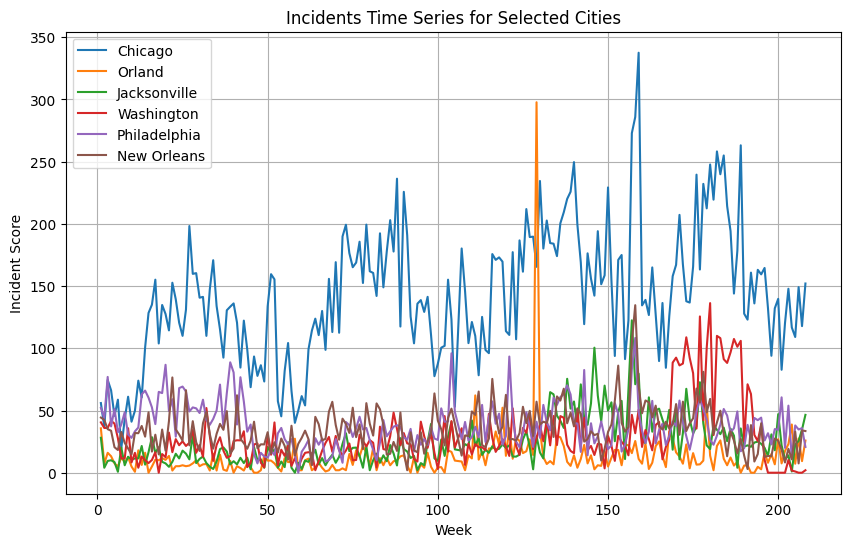

In [18]:
cities_to_plot = ['Chicago', 'Orland', 'Jacksonville', 'Washington', 'Philadelphia', 'New Orleans']
plt.figure(figsize=(10, 6))  # Set the figure size

for city in cities_to_plot:
    plt.plot(time_series.columns, time_series.loc[city], label=city)  # Plot each city's time series

plt.title('Incidents Time Series for Selected Cities')
plt.xlabel('Week')
plt.ylabel('Incident Score')
plt.legend()
plt.grid(True)
plt.show()

DETRENDING:
Check for stationarity using the Augmented Dickey-Fuller test

In [19]:
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller


non_stationary_idx_list = []

with warnings.catch_warnings(record=True):

    for col in tqdm(time_series.columns):
        adf = adfuller(time_series[col])
        pvalue = adf[1]
        if pvalue > 0.05:
            non_stationary_idx_list.append(col)

100%|██████████| 207/207 [00:03<00:00, 65.97it/s]


In [20]:
len(non_stationary_idx_list)

0

In [21]:
from statsmodels.tsa.stattools import adfuller

non_stationary_cities = []

for city in time_series.columns:
    adf = adfuller(time_series[city])
    pvalue = adf[1]
    if pvalue > 0.05:
        non_stationary_cities.append(city)

print(len(non_stationary_cities))

0


In [22]:
time_series_detrend = time_series.copy()
for col in non_stationary_cities:
    time_series_detrend[col] = time_series[col] - time_series[col].rolling(window=12, min_periods=1).mean()

DENOISING

In [23]:
import numpy as np

noise_windows = np.array(range(1, 15))

# Dictionary to store mean SAD scores for each window size
mean_sad_dict = {}

for window_size in noise_windows:
    sum_abs_diff_weeks = []

    for week in time_series_detrend.index:
        smoothed_series = time_series_detrend.loc[week].rolling(window=window_size, center=True, min_periods=1).mean()
        sum_abs_diff_single_per_week = np.sum(np.abs(smoothed_series - time_series_detrend.loc[week]))
        sum_abs_diff_weeks.append(sum_abs_diff_single_per_week)

    mean_sad_dict[window_size] = np.average(sum_abs_diff_weeks)

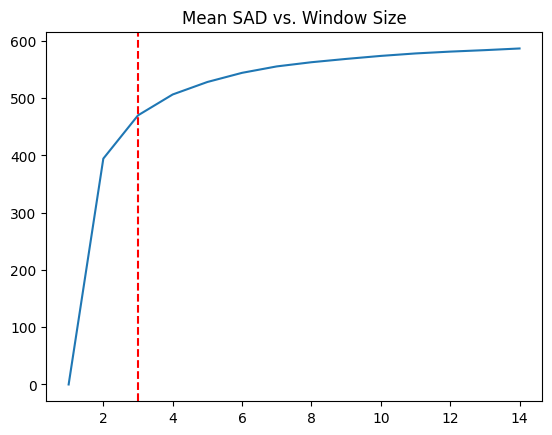

In [24]:
plt.plot(mean_sad_dict.keys(), mean_sad_dict.values())
plt.axvline(3, color='red', linestyle='--')
plt.title('Mean SAD vs. Window Size')
plt.show()

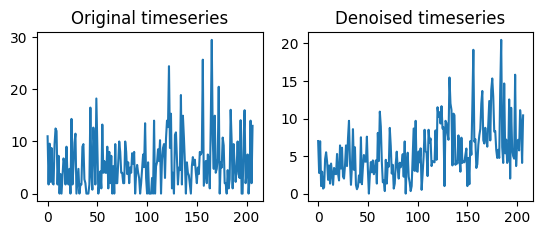

In [25]:
# Denoise the time series with found window size
time_series_denoised = time_series_detrend.rolling(window=3, center=True, min_periods=1).mean()

ts_example = time_series.loc['Austin']
ts_example_denoised = time_series_denoised.loc['Austin']

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(ts_example.to_numpy())
ax1.set_title('Original timeseries')
ax1.set_box_aspect(3 / 4)

ax2.plot(ts_example_denoised.to_numpy())
ax2.set_title('Denoised timeseries')
ax2.set_box_aspect(3 / 4)

plt.show()

SCALING

In [26]:
# Normalize the time series with scaler mean variance
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

scaler = TimeSeriesScalerMeanVariance(0, .1)
time_series_normalized = scaler.fit_transform(time_series_denoised)

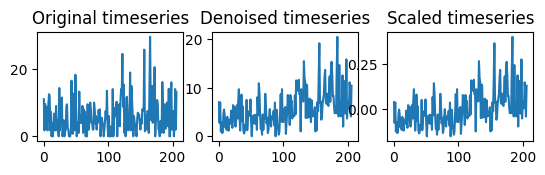

In [27]:
time_series = pd.DataFrame(time_series_normalized.squeeze(axis=-1), columns=time_series_denoised.columns,
                           index=time_series_denoised.index)
ts_example_scaled = time_series.loc['Austin']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(ts_example.to_numpy())
ax1.set_title('Original timeseries')
ax1.set_box_aspect(3 / 4)

ax2.plot(ts_example_denoised.to_numpy())
ax2.set_title('Denoised timeseries')
ax2.set_box_aspect(3 / 4)

ax3.plot(ts_example_scaled.to_numpy())
ax3.set_title('Scaled timeseries')
ax3.set_box_aspect(3 / 4)
plt.show()

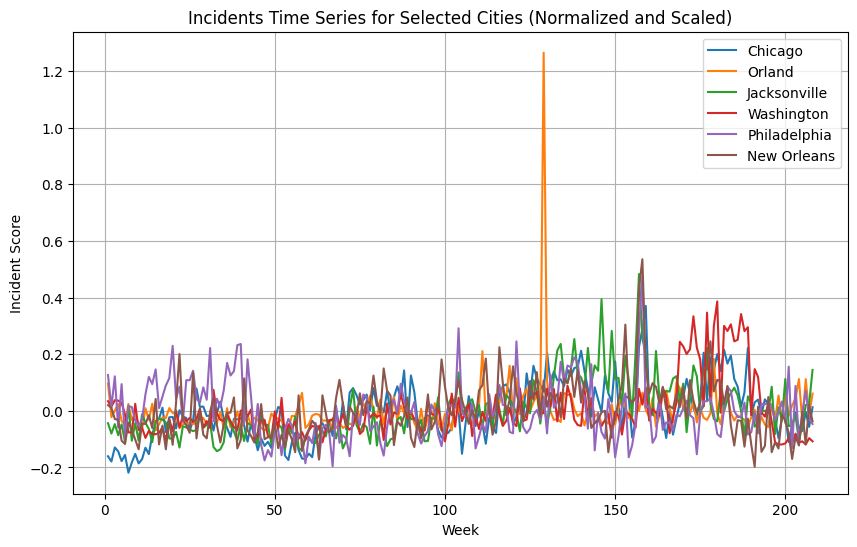

In [28]:
cities_to_plot = ['Chicago', 'Orland', 'Jacksonville', 'Washington', 'Philadelphia', 'New Orleans']


plt.figure(figsize=(10, 6))  # Set the figure size

for city in cities_to_plot:
    plt.plot(time_series.columns, time_series.loc[city], label=city)  # Plot each city's time series

plt.title('Incidents Time Series for Selected Cities (Normalized and Scaled)')
plt.xlabel('Week')
plt.ylabel('Incident Score')
plt.legend()
plt.grid(True)
plt.show()

# CLUSTERING

# SHAPE BASED CLUSTERING: KMEANS

In [90]:
import plotly.express as px


def plot_clustered_time_series(time_series, cluster_labels, n_clusters, colors=['red', 'blue', 'green', 'orange']):
    fig, axs = plt.subplots(n_clusters, figsize=(10, 6), sharex=True)

    for cluster in range(n_clusters):
        cluster_indices = [idx for idx, label in enumerate(cluster_labels) if label == cluster]
        for idx in cluster_indices:
            axs[cluster].plot(time_series.columns, time_series.iloc[idx], color=colors[cluster])

        axs[cluster].set_title(f'Cluster {cluster + 1}')
        axs[cluster].grid(True)
        print(f'Cluster {cluster + 1} length: {len(cluster_indices)}')

    plt.xlabel('Weeks')
    plt.ylabel('Score')
    plt.tight_layout()
    plt.show()

def pie_plot(df_to_plot):
    # Create subplots with 2 rows and 2 columns
    fig, axs = plt.subplots(2, 2, figsize=(10, 5))

    # Plot 'n_participants'
    df_to_plot.groupby('cluster_id')['n_participants'].mean().plot(kind='pie', autopct='%1.1f%%', ax=axs[0, 0])
    axs[0, 0].set_title('Mean Participants per Cluster')

    # Plot 'is_killed'
    df_to_plot.groupby('cluster_id')['is_killed'].mean().plot(kind='pie', autopct='%1.1f%%', ax=axs[0, 1])
    axs[0, 1].set_title('Mean Killed per Cluster')

    # Plot 'male_participation_rate'
    df_to_plot.groupby('cluster_id')['male_participation_rate'].mean().plot(kind='pie', autopct='%1.1f%%', ax=axs[1, 0])
    axs[1, 0].set_title('Mean Males per Cluster')

    # Plot 'arrested_participation_rate'
    df_to_plot.groupby('cluster_id')['arrested_participation_rate'].mean().plot(kind='pie', autopct='%1.1f%%', ax=axs[1, 1])
    axs[1, 1].set_title('Mean Arrested Ratio per Cluster')

    plt.tight_layout()
    plt.show()


def plot_clustered_map(df_to_plot):
    grouped_data = df_to_plot.groupby('city_or_county').agg({'latitude': 'mean', 'longitude': 'mean'}).reset_index()

    cluster_info = df_to_plot[['city_or_county', 'cluster_id']].drop_duplicates()

    grouped_data = pd.merge(grouped_data, cluster_info, on='city_or_county')

    fig = px.scatter_mapbox(grouped_data, lat='latitude', lon='longitude', color='cluster_id',
                            color_continuous_scale='Viridis', zoom=3, height=500,
                            hover_name='city_or_county')

    fig.update_layout(mapbox_style='open-street-map')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})

    fig.show()

KMEANS

In [32]:
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

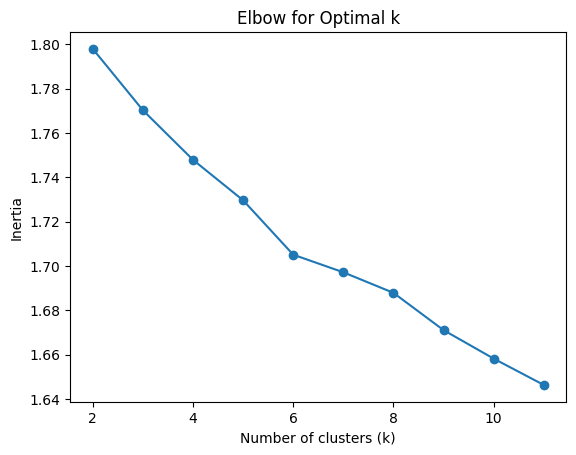

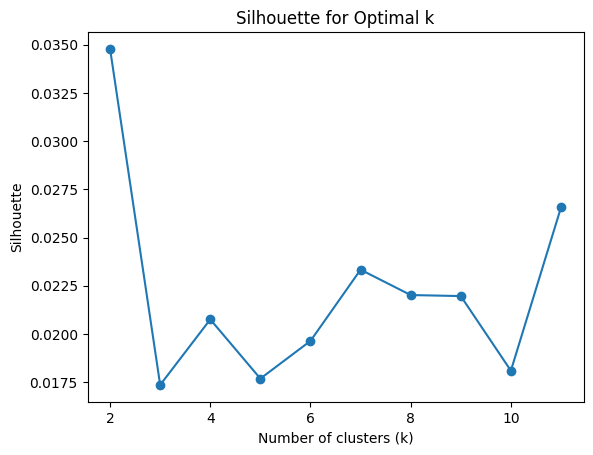

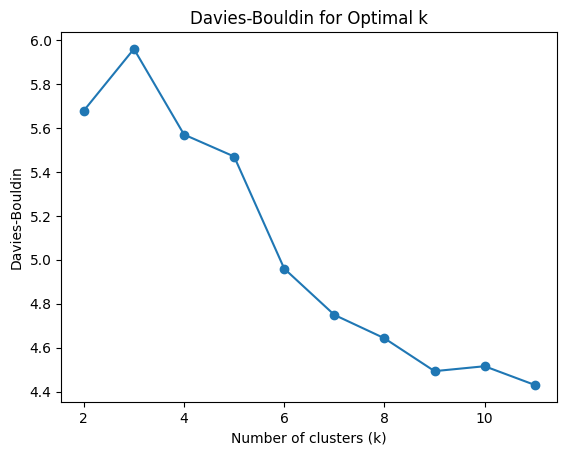

In [33]:
inertia = []
davies_list = []
sil_list = []

for k in range(2, 12):
    model = TimeSeriesKMeans(n_clusters=k, n_init=10, random_state=42)
    model.fit(time_series)
    inertia.append(model.inertia_)
    davies_list.append(davies_bouldin_score(time_series, model.labels_))
    sil_list.append(silhouette_score(time_series, model.labels_))


# Plot the inertia values against k
plt.plot(range(2, 12), inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow for Optimal k')
plt.show()
# Plot the Silhouette values against k
plt.plot(range(2, 12), sil_list, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette')
plt.title('Silhouette for Optimal k')
plt.show()
# Plot the Davies-Bouldin values against k
plt.plot(range(2, 12), davies_list, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin')
plt.title('Davies-Bouldin for Optimal k')
plt.show()

Cluster 1 length: 36
Cluster 2 length: 83
Cluster 3 length: 57
Cluster 4 length: 91
Cluster 5 length: 96
Cluster 6 length: 40


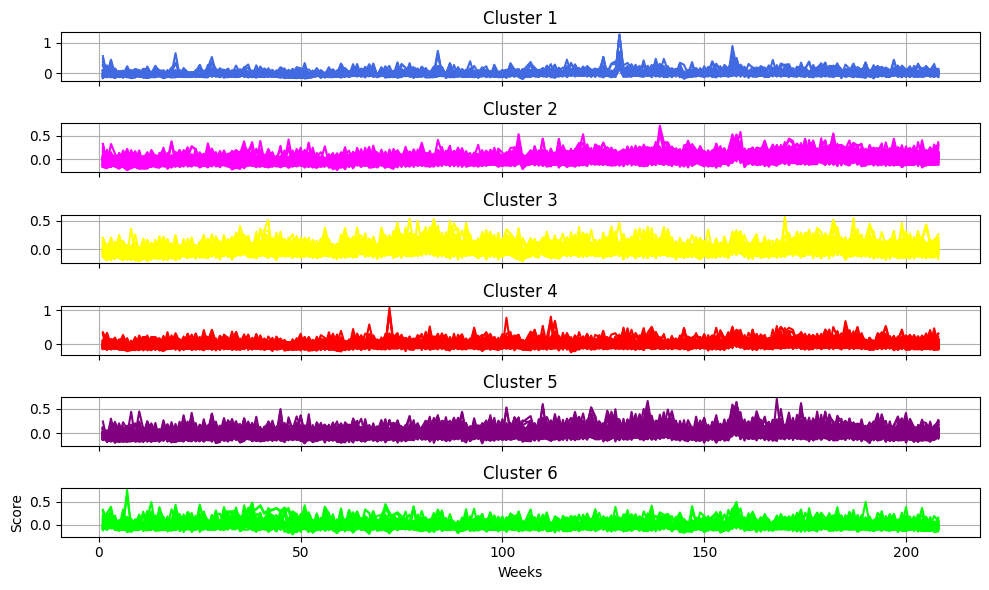

In [44]:
n_clusters = 6  # You can adjust the number of clusters as needed
kmeans = TimeSeriesKMeans(n_clusters=n_clusters, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(time_series)
colors = ['royalblue', 'magenta', 'yellow', 'red', 'purple', 'lime', 'cyan']
plot_clustered_time_series(time_series, cluster_labels, n_clusters, colors)

In [45]:
# create a new dataframe with the cluster labels and the city names
clustered_cities = pd.DataFrame({'city_or_county': time_series.index, 'cluster_id': cluster_labels})
# merge the dataframe with cluster labels with the filtered dataframe
clustered_df = pd.merge(filtered, clustered_cities, on='city_or_county')

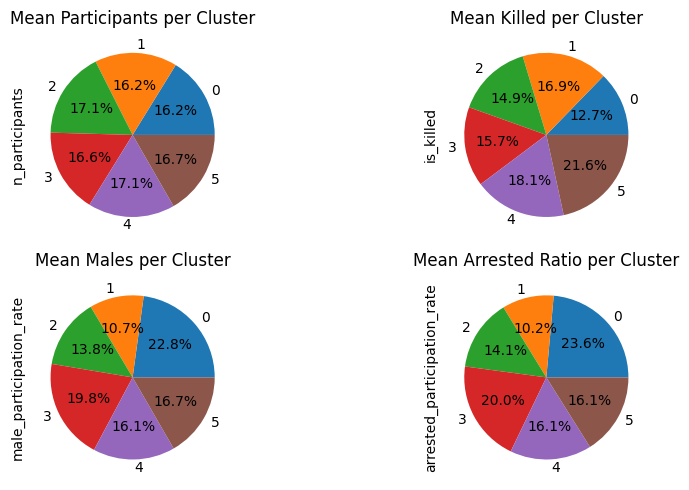

In [46]:
# pie plots of data in each cluster
pie_plot(clustered_df)

In [47]:
plot_clustered_map(clustered_df)

DIMENSIONAL TIME WARPING

In [ ]:
distortions = []
davies_list = []
sil_list = []

K = range(2, 12)  # Test k values
for k in K:
    km = TimeSeriesKMeans(n_clusters=k, metric="dtw", verbose=0, random_state=42, n_init=5)
    km.fit(time_series)
    distortions.append(km.inertia_)
    davies_list.append(davies_bouldin_score(time_series, km.labels_))
    sil_list.append(silhouette_score(time_series, km.labels_))

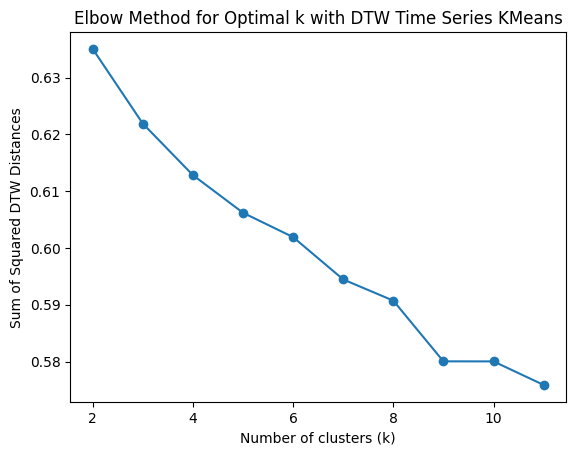

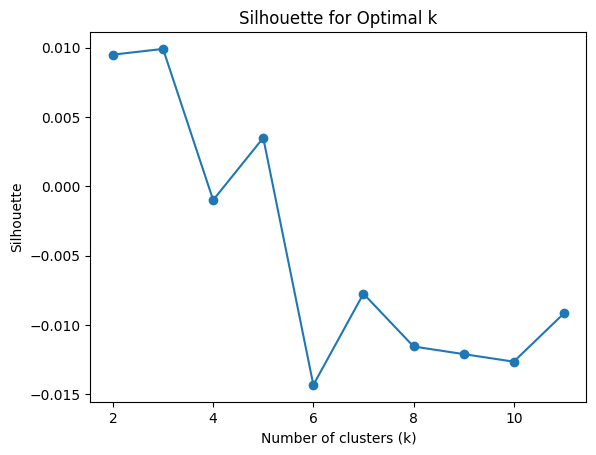

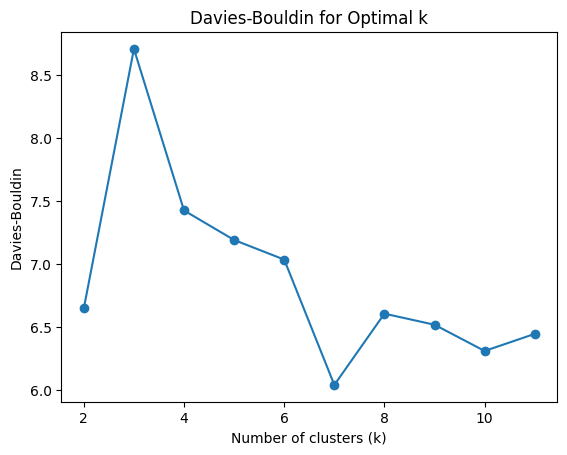

In [ ]:
# Plotting the elbow method graph
plt.plot(K, distortions, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared DTW Distances')
plt.title('Elbow Method for Optimal k with DTW Time Series KMeans')
plt.show()
# Plot the Silhouette values
plt.plot(K, sil_list, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette')
plt.title('Silhouette for Optimal k')
plt.show()
# Plot the Davies-Bouldin values
plt.plot(K, davies_list, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin')
plt.title('Davies-Bouldin for Optimal k')
plt.show()

Cluster 1 length: 65
Cluster 2 length: 57
Cluster 3 length: 135
Cluster 4 length: 47
Cluster 5 length: 48
Cluster 6 length: 51


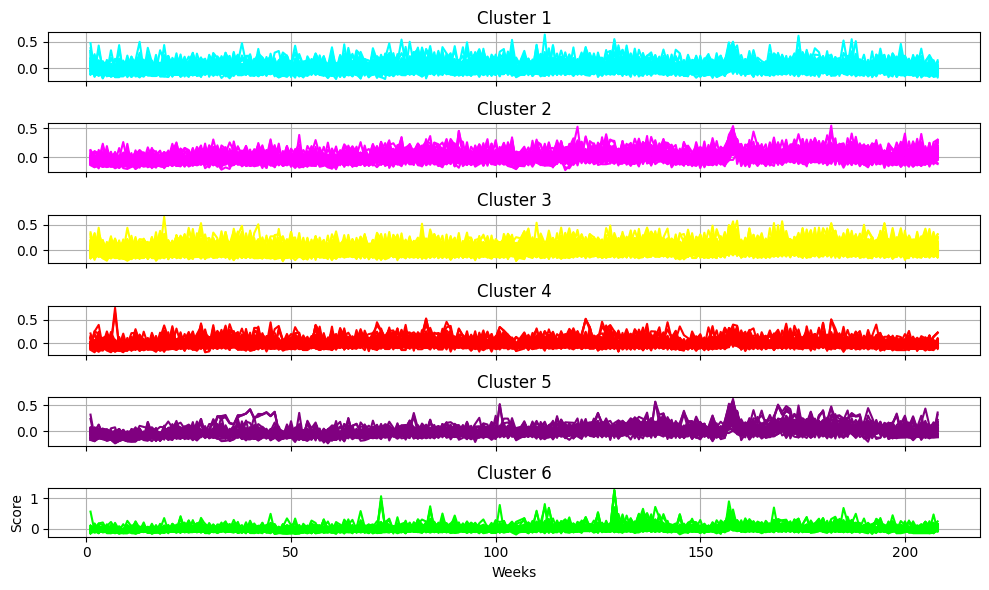

In [ ]:
n_clusters = 6
kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_init=5, random_state=42)
cluster_labels = kmeans_dtw.fit_predict(time_series)

colors = ['cyan', 'magenta', 'yellow', 'red', 'purple', 'lime']

plot_clustered_time_series(time_series, kmeans_dtw.labels_, n_clusters, colors)

In [ ]:
# create a new dataframe with the cluster labels and the city names
clustered_cities_dtw = pd.DataFrame({'city_or_county': time_series.index, 'cluster_id': cluster_labels})
# merge the dataframe with cluster labels with the filtered dataframe
clustered_df_dtw = pd.merge(filtered, clustered_cities_dtw, on='city_or_county')

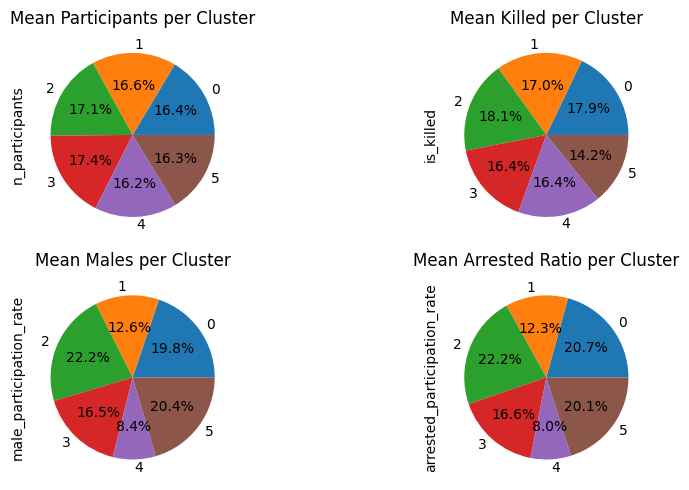

In [ ]:
# pie plots of data in each cluster
pie_plot(clustered_df_dtw)

# FEATURE BASED CLUSTERING

In [ ]:
import scipy.stats as stats

# calculate the features for each time series, to use them for clustering
def calculate_features(values):
    features = {
        'avg': np.mean(values, axis=0),
        'std': np.std(values, axis=0),
        'var': np.var(values, axis=0),
        'med': np.median(values, axis=0),
        '10p': np.percentile(values, 10, axis=0),
        '25p': np.percentile(values, 25, axis=0),
        '50p': np.percentile(values, 50, axis=0),
        '75p': np.percentile(values, 75, axis=0),
        '90p': np.percentile(values, 90, axis=0),
        'iqr': np.percentile(values, 75, axis=0) - np.percentile(values, 25, axis=0),
        'skw': stats.skew(values, axis=0),
        'kur': stats.kurtosis(values, axis=0)
    }

    return features

In [ ]:
time_series_features = [list(calculate_features(ts.values).values()) for _, ts in time_series.iterrows()]

KMEANS

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans


def k_means_calculation(df):
    sse, davies, silhouette = [], [], []
    max_k = 15
    for k in range(2, max_k + 1):
        kmeans_pass = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
        kmeans_pass.fit(df)
        sse_pass = kmeans_pass.inertia_
        sse.append(sse_pass)
        davies.append(davies_bouldin_score(df, kmeans_pass.labels_))
        silhouette.append(silhouette_score(df, kmeans_pass.labels_))
    plt.plot(range(2, len(sse) + 2), sse)
    plt.ylabel('SSE')
    plt.xlabel('K')
    plt.title('SSE')
    plt.show()
    plt.plot(range(2, len(davies) + 2), davies)
    plt.ylabel('DAVIES')
    plt.xlabel('K')
    plt.title('DAVIES')
    plt.show()
    plt.plot(range(2, len(silhouette) + 2), silhouette)
    plt.ylabel('SILHOUETTE')
    plt.xlabel('K')
    plt.title('SILHOUETTE')
    plt.show()

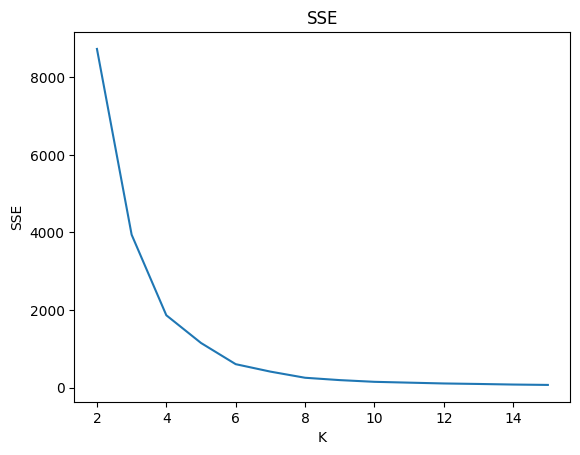

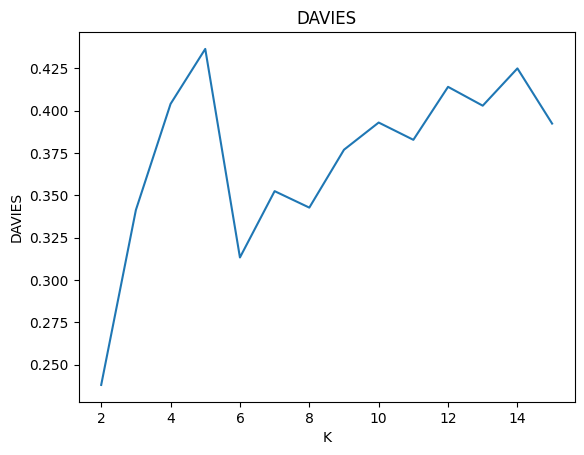

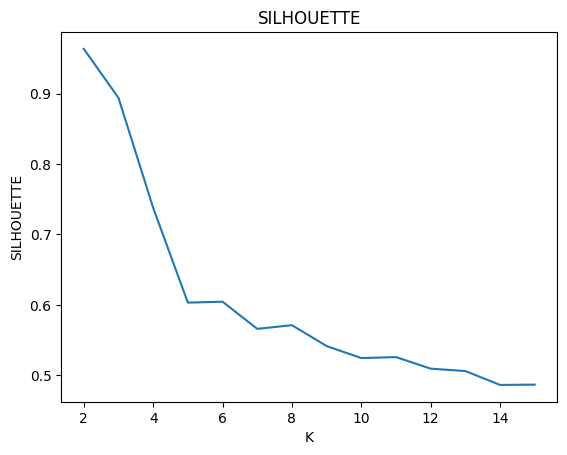

In [ ]:
k_means_calculation(time_series_features)

In [ ]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
kmeans.fit(time_series_features)

KMeans(n_clusters=4, n_init=10, random_state=42)

Cluster 1 length: 35
Cluster 2 length: 3
Cluster 3 length: 4
Cluster 4 length: 361


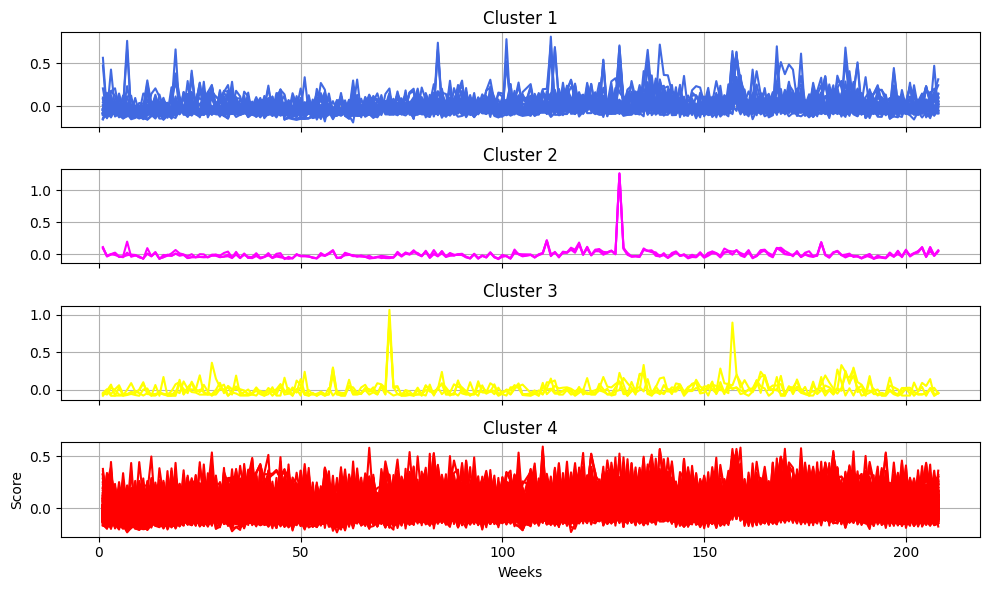

In [ ]:
colors = ['royalblue', 'magenta', 'yellow', 'red', 'purple', 'lime', 'cyan']
cluster_labels = kmeans.labels_
plot_clustered_time_series(time_series, cluster_labels, n_clusters, colors)

In [ ]:
# create a new dataframe with the cluster labels and the city names
clustered_cities = pd.DataFrame({'city_or_county': time_series.index, 'cluster_id': cluster_labels})
# merge the dataframe with cluster labels with the filtered dataframe
clustered_df = pd.merge(filtered, clustered_cities, on='city_or_county')

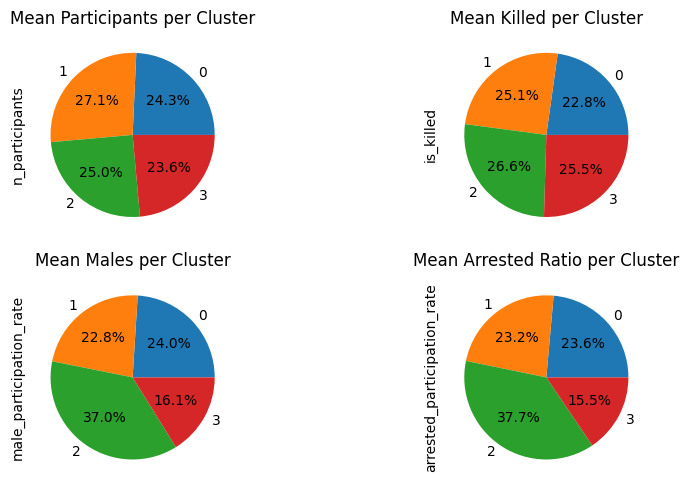

In [ ]:
pie_plot(clustered_df)

# HIERARCHICAL CLUSTERING

In [ ]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler

X_std = StandardScaler().fit_transform(time_series_features)
X_minmax = MinMaxScaler().fit_transform(time_series_features)

Standard scaling


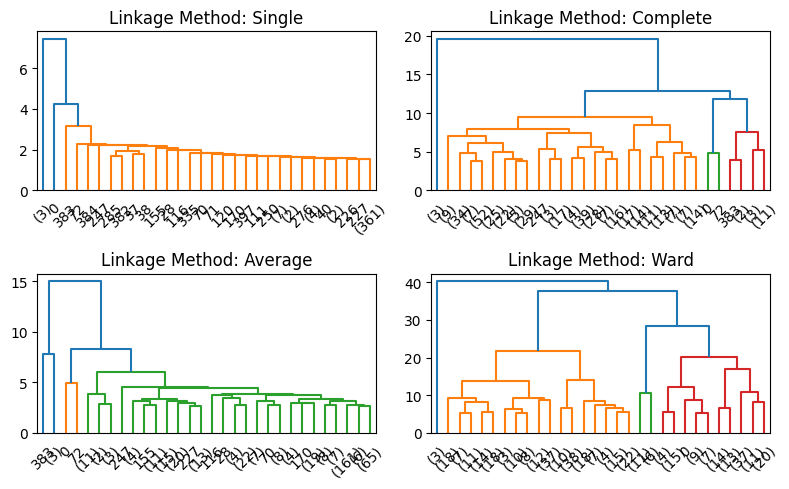

In [ ]:
# List of linkage methods
linkage_methods = ['single', 'complete', 'average', 'ward']

print("Standard scaling")
# Calculating pairwise distances
data_dist = pdist(X_std, metric='euclidean')
color_tresholds = [4, 10, 7, 25]

# Creating subplots for each dendrogram
fig, axs = plt.subplots(2, 2, figsize=(8, 5))

for i, method in enumerate(linkage_methods):
    # Calculate linkage for each method
    data_link = linkage(data_dist, method=method, metric='euclidean')

    # Determine subplot position
    row = i // 2
    col = i % 2

    # Plot dendrogram for each method
    dendrogram(data_link, ax=axs[row, col], color_threshold=color_tresholds[i], truncate_mode='lastp')
    axs[row, col].set_title(f"Linkage Method: {method.capitalize()}")

# Adjust layout and display
plt.tight_layout()
plt.show()

Minmax scaling


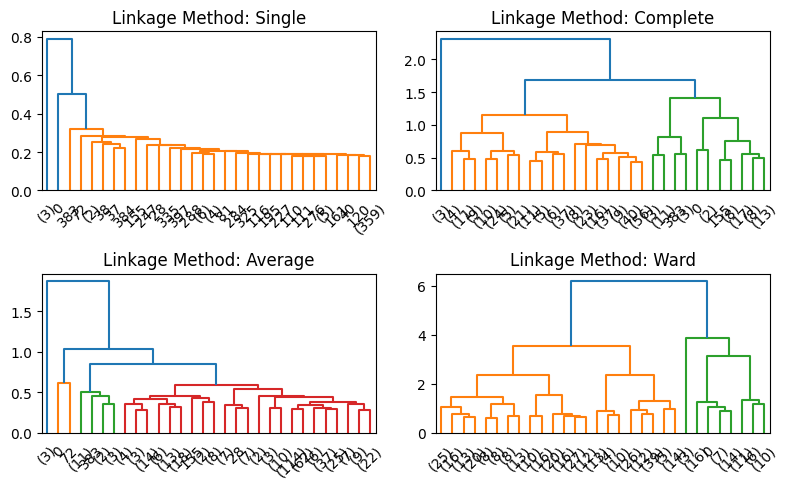

In [ ]:
print("Minmax scaling")

# Calculating pairwise distances
data_dist = pdist(X_minmax, metric='euclidean')
color_tresholds = [0.5, 1.5, 0.8, 5]

# Creating subplots for each dendrogram
fig, axs = plt.subplots(2, 2, figsize=(8, 5))

for i, method in enumerate(linkage_methods):
    # Calculate linkage for each method
    data_link = linkage(data_dist, method=method, metric='euclidean')

    # Determine subplot position
    row = i // 2
    col = i % 2

    # Plot dendrogram for each method
    dendrogram(data_link, ax=axs[row, col], color_threshold=color_tresholds[i], truncate_mode='lastp')
    axs[row, col].set_title(f"Linkage Method: {method.capitalize()}")

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

def hierarchical_clustering_test(X, n_clusters, linkage_method):
    hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage=linkage_method)
    cluster_labels = hierarchical_clustering.fit_predict(X)
    sil_score = silhouette_score(X, hierarchical_clustering.labels_)
    print(f"Silhouette Score (n_clusters={n_clusters}, linkage={linkage_method}): {sil_score}")
    unique_clusters, cluster_counts = np.unique(cluster_labels, return_counts=True)
    for cluster_id, count in zip(unique_clusters, cluster_counts):
        print(f"Cluster {cluster_id}: {count} points")

In [ ]:
# Test the clustering with different configurations
hierarchical_clustering_test(X_std, n_clusters=2, linkage_method='ward')
hierarchical_clustering_test(X_minmax, n_clusters=2, linkage_method='ward')
hierarchical_clustering_test(X_minmax, n_clusters=3, linkage_method='ward')

Silhouette Score (n_clusters=2, linkage=ward): 0.7766905790699373
Cluster 0: 400 points
Cluster 1: 3 points
Silhouette Score (n_clusters=2, linkage=ward): 0.44541910845911215
Cluster 0: 68 points
Cluster 1: 335 points
Silhouette Score (n_clusters=3, linkage=ward): 0.42916545554482594
Cluster 0: 335 points
Cluster 1: 65 points
Cluster 2: 3 points


In [ ]:
hierarchical_clustering = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage="ward")
cluster_labels = hierarchical_clustering.fit_predict(X_std)
cluster_labels2 = hierarchical_clustering.fit_predict(X_minmax)

In [ ]:
# create a new dataframe with the cluster labels and the city names
clustered_cities = pd.DataFrame({'city_or_county': time_series.index, 'cluster_id': cluster_labels})
clustered_cities2 = pd.DataFrame({'city_or_county': time_series.index, 'cluster_id': cluster_labels2})

# merge the dataframe with cluster labels with the filtered dataframe
clustered_df = pd.merge(filtered, clustered_cities, on='city_or_county')
clustered_df2 = pd.merge(filtered, clustered_cities2, on='city_or_county')

Cluster 1 length: 400
Cluster 2 length: 3


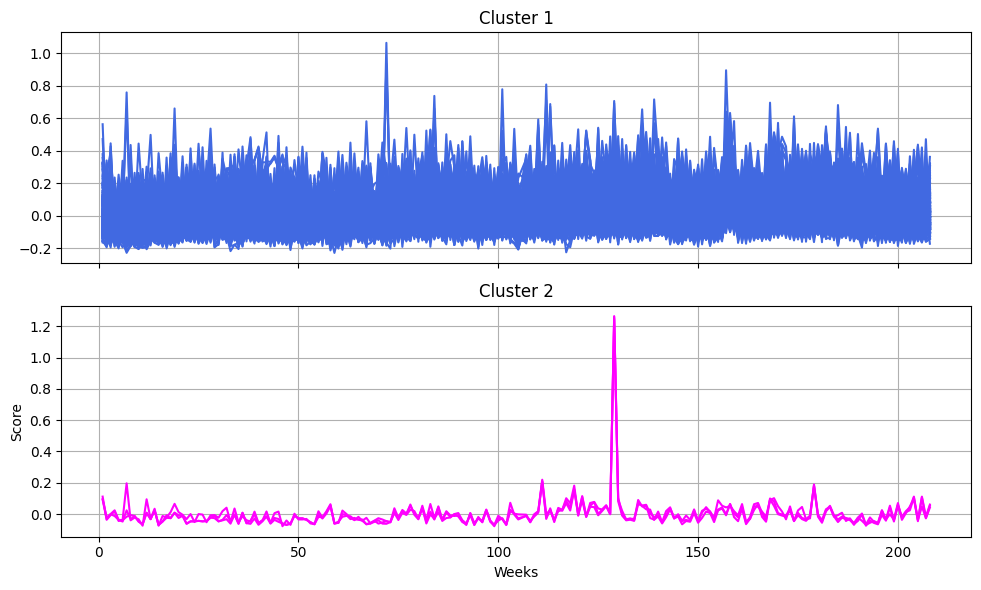

Cluster 1 length: 68
Cluster 2 length: 335


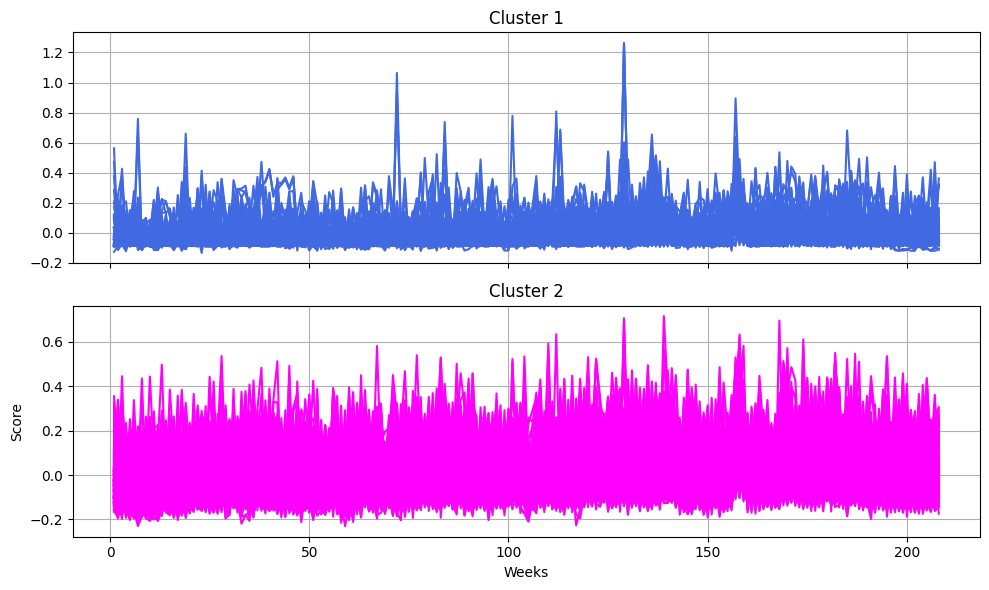

In [ ]:
plot_clustered_time_series(time_series, cluster_labels, 2,colors = ['royalblue', 'magenta'])
plot_clustered_time_series(time_series, cluster_labels2, 2,colors = ['royalblue', 'magenta'])


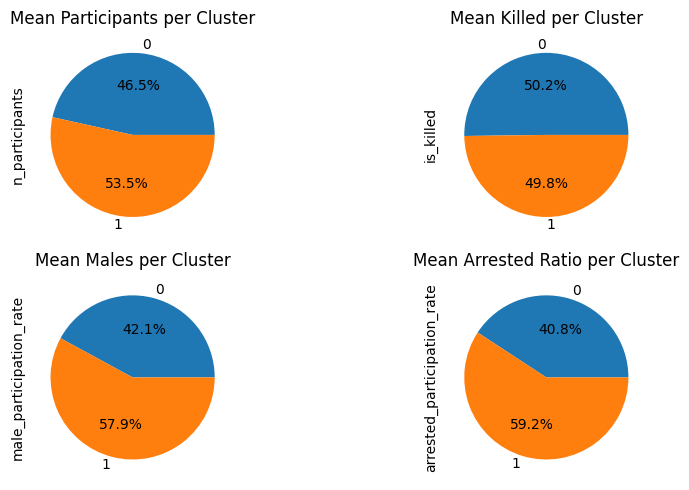

In [ ]:
pie_plot(clustered_df)

# MOTIFS/ANOMALIES EXTRACTION

We take the results from the DTW clustering and find the most similar time series to each cluster's centroid. We will use the DTW distance to find the most similar time series to each centroid, which will be used for motif discovery and anomaly detection

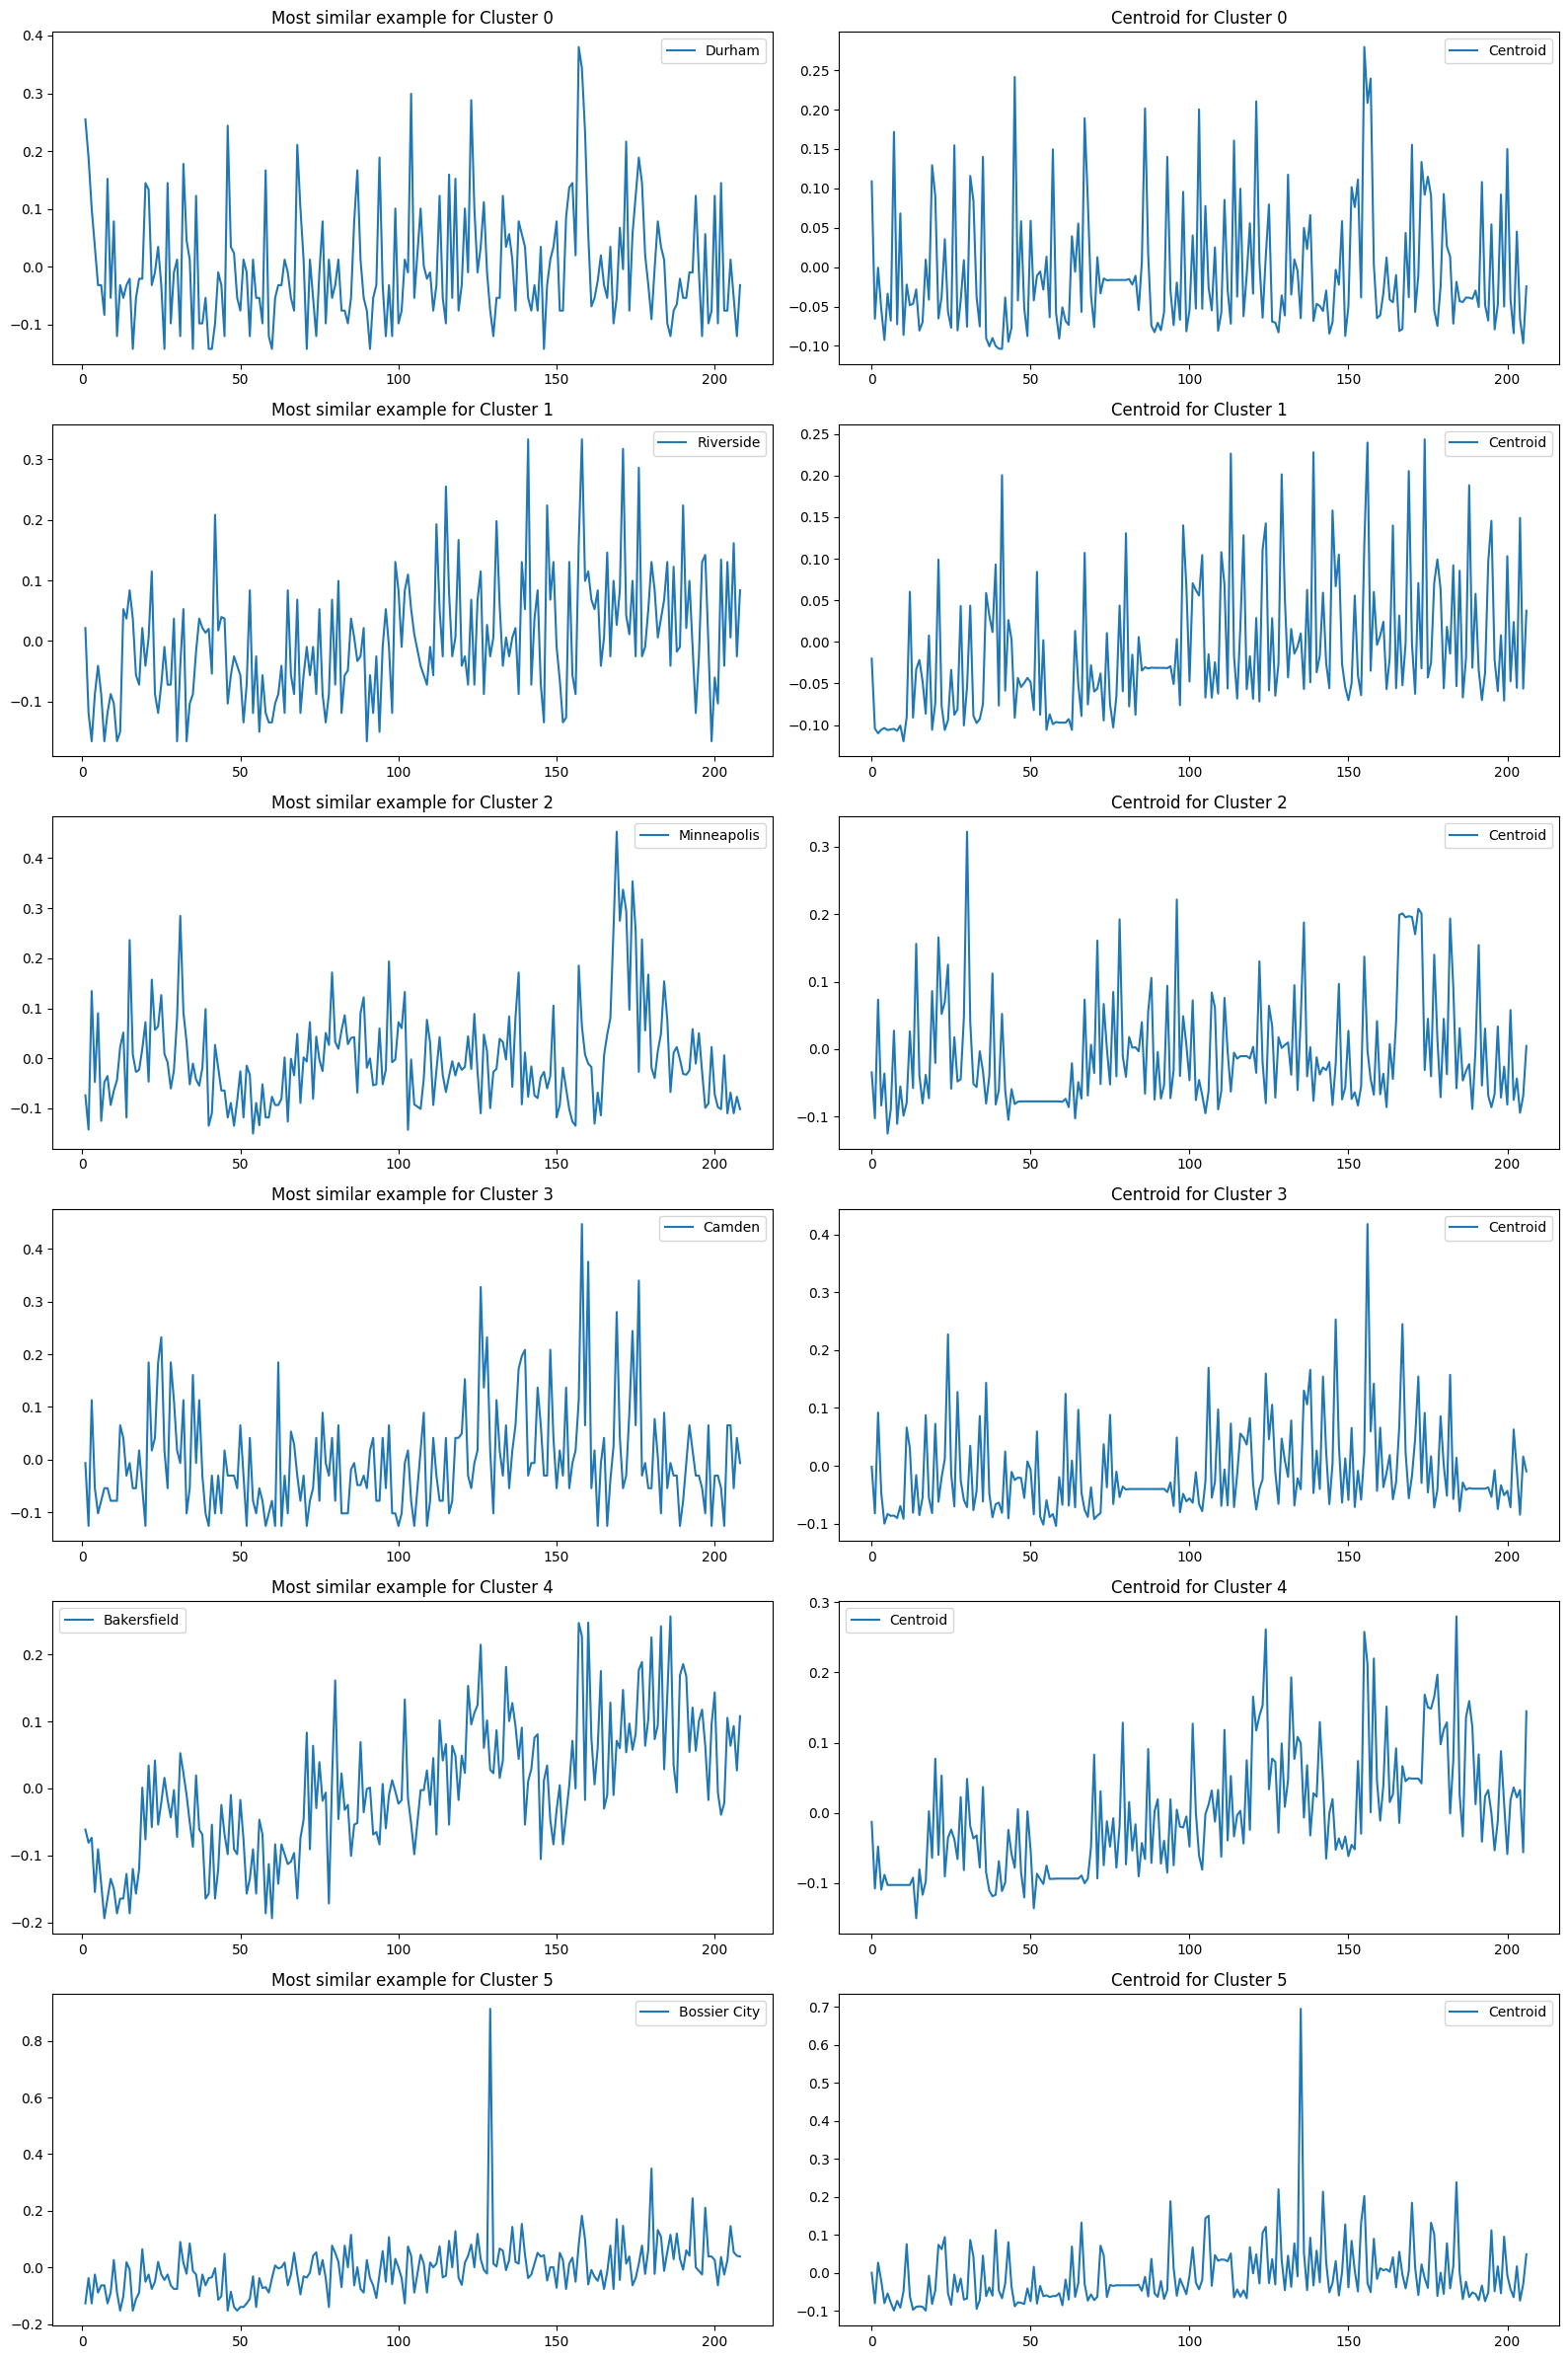

In [ ]:
from tslearn.metrics import cdist_dtw
import numpy as np

kmeans_labels = kmeans_dtw.labels_
kmeans_centroids = kmeans_dtw.cluster_centers_

# Create an empty dictionary to store motifs for each cluster
cluster_ex = {}

# Find and plots the time series most similar to each cluster's centroid
unique_clusters = np.unique(kmeans_labels)
for cluster_label in unique_clusters:
    # Select time series belonging to the current cluster
    cluster_indices = np.where(kmeans_labels == cluster_label)[0]
    cluster_time_series = time_series.iloc[cluster_indices]

    # Calculate DTW distances between each series and centroid of the cluster
    centroid = kmeans_centroids[cluster_label]
    distances = cdist_dtw(cluster_time_series.values, [centroid])

    # Find the index of the time series closest to the centroid (most similar)
    most_similar_idx = np.argmin(distances)

    # Store the most similar time series as the motif for this cluster
    cluster_ex[cluster_label] = cluster_time_series.iloc[most_similar_idx]

fig, axes = plt.subplots(nrows=len(cluster_ex), ncols=2, figsize=(16, 4 * len(cluster_ex)))

for i, (cluster_label, motif) in enumerate(cluster_ex.items()):
    centroid = kmeans_centroids[cluster_label]  # Centroid for the current cluster

    axes[i, 0].plot(motif, label=motif.name)
    axes[i, 0].set_title(f'Most similar example for Cluster {cluster_label}')
    axes[i, 0].legend()

    axes[i, 1].plot(centroid, label='Centroid')
    axes[i, 1].set_title(f'Centroid for Cluster {cluster_label}')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
pip install matrixprofile-ts

In [ ]:
from matrixprofile import *
from matrixprofile.discords import discords
import matplotlib.pyplot as plt

# for each motif candidate, use find the motifs of the cluster
w = 4  # 4 weeks to look for monthly patterns

Cluster 1


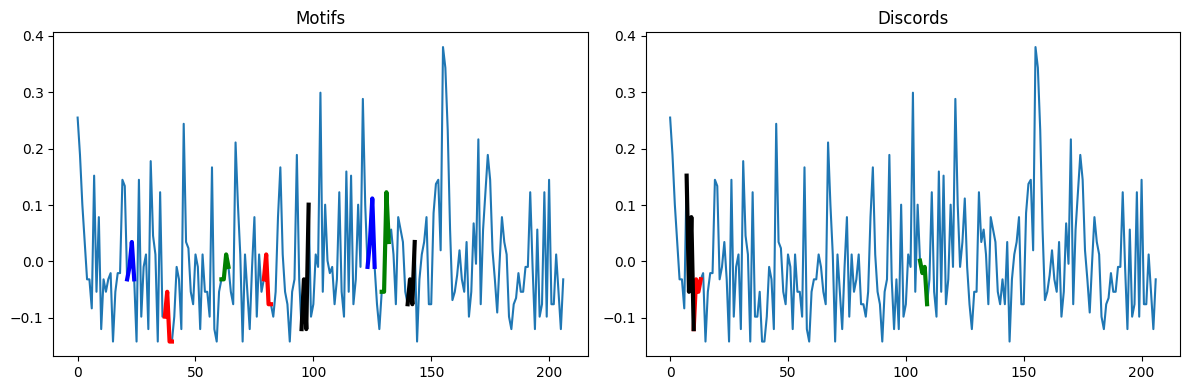

Cluster 2


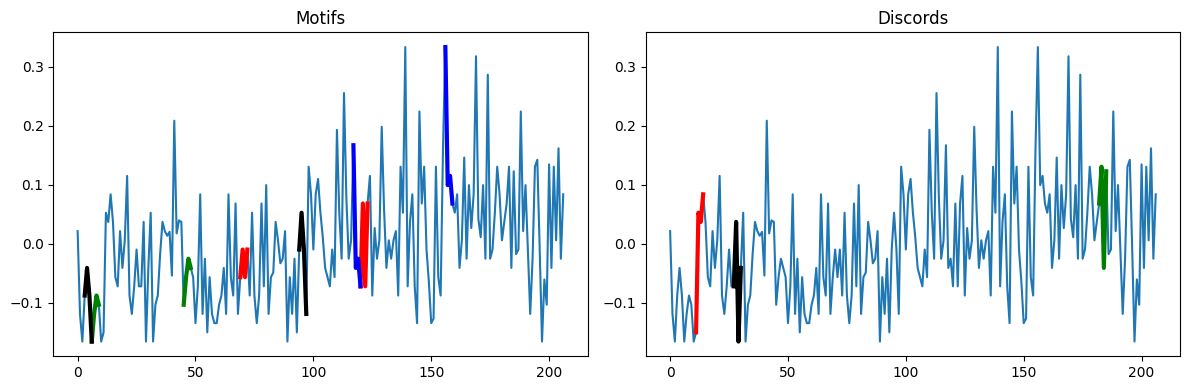

Cluster 3


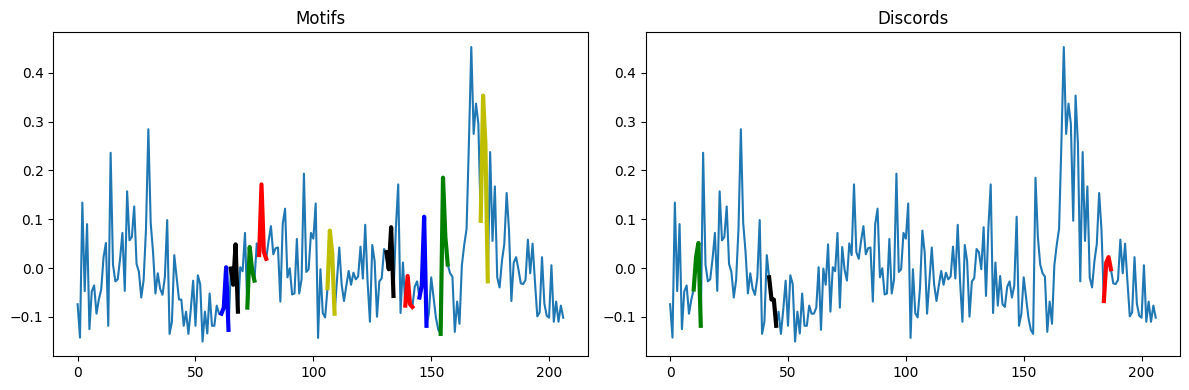

Cluster 4


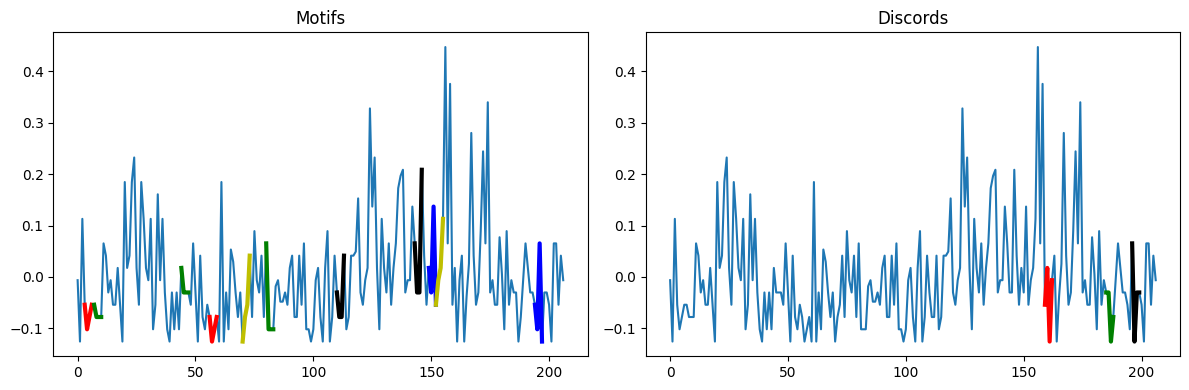

Cluster 5


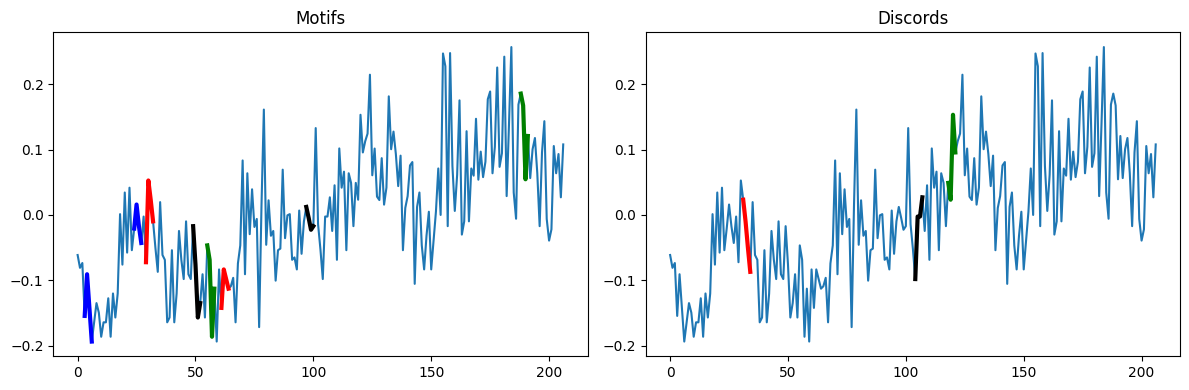

Cluster 6


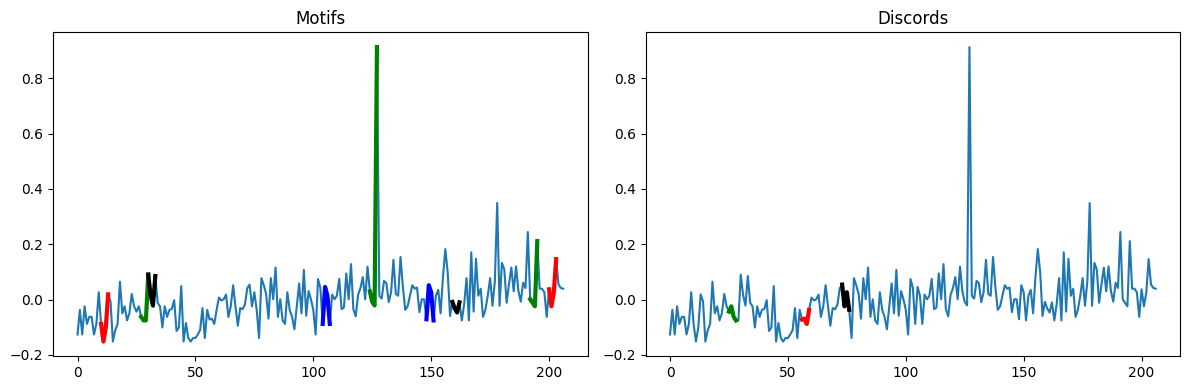

In [ ]:
for cluster_label, ts in cluster_ex.items():
    print(f'Cluster {cluster_label + 1}')
    mp, mpi = matrixProfile.stomp(ts.values, w)

    mo, mod = motifs.motifs(ts.values, (mp, mpi), max_motifs=5)
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(ts.values)
    colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
    for m, d, c in zip(mo, mod, colors):
        for i in m:
            m_shape = ts.values[i:i + w]
            plt.plot(range(i, i + w), m_shape, color=c, lw=3)
    plt.title('Motifs')

    plt.subplot(122)
    try:
        anoms = discords(mp, ex_zone=2, k=3)
    except:
        anoms = []
    plt.plot(ts.values)
    colors = ['r', 'g', 'k', 'b', 'y'][:len(anoms)]
    for a, c in zip(anoms, colors):
        a_shape = ts.values[a:a + w]
        plt.plot(range(a, a + w), a_shape, color=c, lw=3)
    plt.title('Discords')

    plt.tight_layout()
    plt.show()

# SHAPELET EXTRACTION

In [60]:
df = pd.read_csv('/content/drive/MyDrive/TASK4DATA.csv')

In [50]:
print(df['city_or_county'].nunique())

10902


In [64]:
df = df[(df['year'] >= 2014) & (df['year'] <= 2017)]
df["is_killed"] = df["n_killed"] > 0

# Group counties by state
grouped_by_state = df.groupby('state')['city_or_county'].unique()

In [ ]:
from fuzzywuzzy import fuzz
import pandas as pd

# Function to unify similar names using fuzzy matching
def unify_similar_names(names):
    mapping_dict = {}

    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            similarity_ratio = fuzz.ratio(names[i], names[j])
            if similarity_ratio > 90:  # Adjust the threshold as needed
                print(f"Similarity between '{names[i]}' and '{names[j]}' - Ratio: {similarity_ratio}")
                mapping_dict[names[j]] = names[i]

    return mapping_dict

# Assuming df is your DataFrame and 'city_or_county' is the column with county names
counties = df['city_or_county'].unique()

# Call the function to get the mapping dictionary
unify_dict_auto = unify_similar_names(counties)

# Apply the automatic mapping to unify similar names
df['city_or_county'] = df['city_or_county'].replace(unify_dict_auto)

Similarity between 'Ashville' and 'Asheville' - Ratio: 94
Similarity between 'Bessemer' and 'Bessemer ' - Ratio: 94
Similarity between 'Blount' and 'Blunt' - Ratio: 91
Similarity between 'Blountsville' and 'Blountville' - Ratio: 96
Similarity between 'Bryant' and 'Bryan' - Ratio: 91
Similarity between 'Bullock County' and 'Bulloch County' - Ratio: 93
Similarity between 'Centreville' and 'Centerville' - Ratio: 91
Similarity between 'Clanton' and 'Canton' - Ratio: 92
Similarity between 'Coaling' and 'Coalinga' - Ratio: 93
Similarity between 'Coden' and 'Cowden' - Ratio: 91
Similarity between 'Coden' and 'Colden' - Ratio: 91
Similarity between 'Coosa (county)' and 'Catoosa (county)' - Ratio: 93
Similarity between 'Coosa (county)' and 'Coos (county)' - Ratio: 96
Similarity between 'Coosa County' and 'Catoosa County' - Ratio: 92
Similarity between 'Coosa County' and 'Coos County' - Ratio: 96
Similarity between 'Danville' and 'Dansville' - Ratio: 94
Similarity between 'DeKalb (county)' and '

In [52]:
print(df['city_or_county'].nunique())


10902


In [65]:
# preprocess county names to unify typos and different abbreviations
counties = df['city_or_county'].unique()
# Apply a regex-based replacement to unify the "county" suffix
df['city_or_county'] = df['city_or_county'].str.replace(r'\s+\(county\)$', ' County', regex=True)
# Replace punctuation characters with spaces
df['city_or_county'] = df['city_or_county'].str.replace(r'[^\w\s]|(?<=\w)-(?=\w)', ' ', regex=True)
# Replace 'St ' with 'Saint'
df['city_or_county'] = df['city_or_county'].str.replace(r'\bSt\b', 'Saint', regex=True)
# Replace "Pk" with "Park"
df['city_or_county'] = df['city_or_county'].str.replace(r'\bPk\b', 'Park', regex=True)
# Replace "Mt" with "Mount"
df['city_or_county'] = df['city_or_county'].str.replace(r'\bMt\b', 'Mount', regex=True)
# Replace "Twp" with "Township"
df['city_or_county'] = df['city_or_county'].str.replace(r'\bTwp\b', 'Township', regex=True)
# Replace "Washingtn" with "Washington"
df['city_or_county'] = df['city_or_county'].str.replace(r'\bWashingtn\b', 'Washington', regex=True)

# Remove extra spaces
df['city_or_county'] = df['city_or_county'].str.replace(r'\s+', ' ', regex=True)
# Transform to title case and strip leading and trailing spaces
df['city_or_county'] = df['city_or_county'].str.strip().str.title()

# Define a function to calculate the unique week index considering leap years
def calculate_unique_week(date):
    if date.year == 2016:  # account for the leap year
        return date.isocalendar().week + (date.year - 2014) * 53
    else:
        return date.isocalendar().week + (date.year - 2014) * 52

# Apply the function to create the unique week index column
df['week'] = df['date'].apply(calculate_unique_week)

In [66]:
df['teen_participation_rate'] = df['teen_participation_rate'].fillna(0)
df['child_participation_rate'] = df['child_participation_rate'].fillna(0)

df['score'] = (2 * (df.teen_participation_rate + df.child_participation_rate)) + (df.n_participants - (df.teen_participation_rate + df.child_participation_rate))

In [67]:
grouped = df.groupby([df['city_or_county'],
                      df['week']])['score'].sum().reset_index()

ts = grouped.pivot(index='city_or_county', columns='week', values=['score'])
ts.fillna(0, inplace=True)

In [68]:
target_df = df.drop_duplicates(subset='city_or_county')
Y = target_df['is_killed']

In [69]:
from sklearn.model_selection import train_test_split

X = ts.values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [70]:
n_ts, ts_sz = X_train.shape
n_classes = 2

shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.02,
                                                       r=1)
print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 8721
ts_sz 207
n_classes 2
shapelet_sizes {4: 6}


In [71]:
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            max_iter=100,
                            random_state=42,
                            verbose=1)
shp_clf.fit(X_train, y_train)
y_pred_test = shp_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_test))

Epoch 1/100
35/35 [==============================] - 2s 16ms/step - loss: 25726.9453 - binary_accuracy: 0.5551 - binary_crossentropy: 25726.9453
Epoch 2/100
35/35 [==============================] - 1s 15ms/step - loss: 3518.9209 - binary_accuracy: 0.5646 - binary_crossentropy: 3518.9209
Epoch 3/100
35/35 [==============================] - 1s 16ms/step - loss: 1580.7269 - binary_accuracy: 0.5630 - binary_crossentropy: 1580.7269
Epoch 4/100
35/35 [==============================] - 1s 19ms/step - loss: 916.8162 - binary_accuracy: 0.5655 - binary_crossentropy: 916.8162
Epoch 5/100
35/35 [==============================] - 1s 27ms/step - loss: 588.8832 - binary_accuracy: 0.5700 - binary_crossentropy: 588.8832
Epoch 6/100
35/35 [==============================] - 1s 25ms/step - loss: 431.5461 - binary_accuracy: 0.5690 - binary_crossentropy: 431.5461
Epoch 7/100
35/35 [==============================] - 1s 25ms/step - loss: 340.0804 - binary_accuracy: 0.5595 - binary_crossentropy: 340.0804
Epoch

9/9 [==============================] - 0s 8ms/step


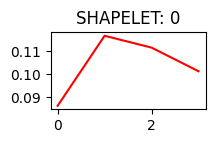

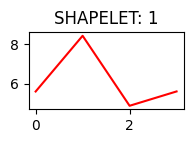

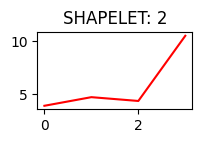

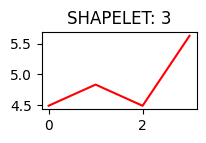

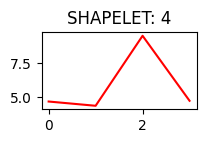

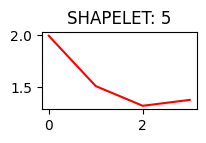

In [72]:
predicted_locations = shp_clf.locate(X_test)
for i, shp in enumerate(shp_clf.shapelets_as_time_series_):
    plt.figure(figsize=(2, 1))
    plt.title(f"SHAPELET: {i}")
    plt.plot(shp, color='red')
    plt.show()

We apply it on a timeseries to see how close it is

In [73]:
indices_sorted_by_values = np.argsort(X_test.sum(axis=1))[::-1]

# Now 'indices_sorted_by_values' contains the indices sorted by values in descending order
top_3_indices = indices_sorted_by_values[:3]

# Print the top 3 indices
print('Top 3 indices with highest values:', top_3_indices)


Top 3 indices with highest values: [1257 2095  384]


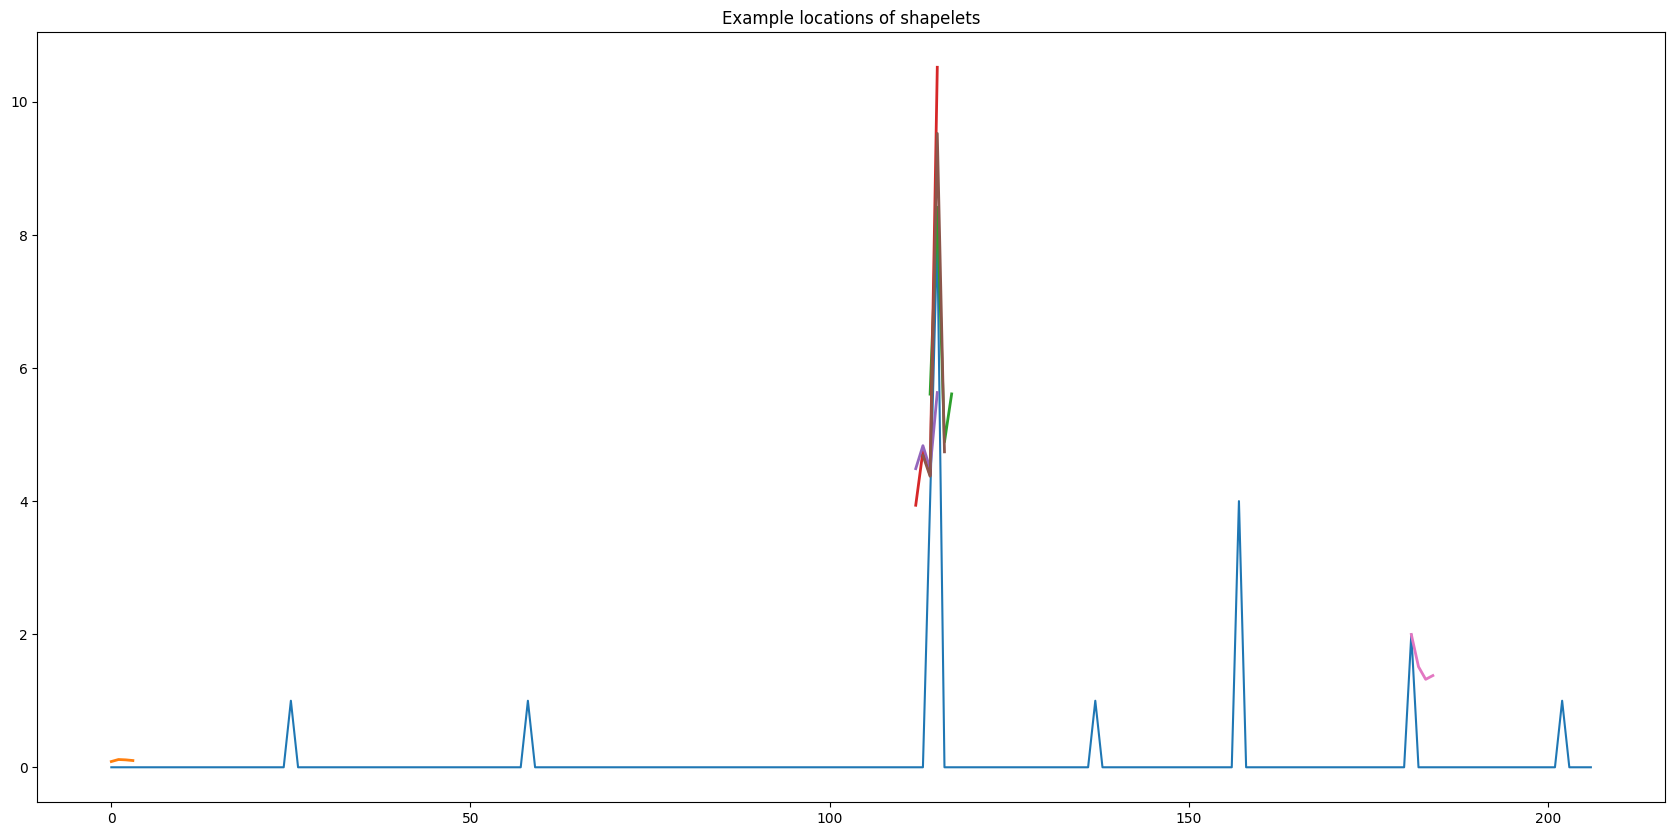

In [89]:
ts_id = 9
plt.figure(figsize=(21., 10.))
plt.plot(X_test[ts_id].ravel())
count = 0
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)
plt.title("Example locations of shapelets")
plt.show()